In [1]:
import os
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from isca_tools.thesis.adiabat_theory import get_theory_prefactor_terms, get_temp_adiabat_surf

print(os.getcwd())  # check local
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import cartopy.mpl.ticker as cticker
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import metpy
import scipy.stats as sts
from glob import glob
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import re
import warnings
import isca_tools
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils import area_weighting, set_attrs
from isca_tools.utils.base import round_any
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.convection.base import lcl_metpy, dry_profile_temp, moist_profile
from isca_tools.thesis.lapse_theory import get_bulk_lapse_rate, reconstruct_temp, interp_var_at_pressure
from isca_tools.utils.moist_physics import sphum_sat, sphum_from_dew, moist_static_energy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
import copy
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/Users/joshduffield/Documents/StAndrews/Isca/jobs/theory_lapse


In [61]:
# Figure formatting
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7


plt.rc('axes', linewidth=0.5)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

## Save Hot day dataset
Save information for hottest 5% of days at each coordinate. Include all data required to do SQE decomposition of what sets variation in temperature spatially.

In [3]:
%%time
exp_dir = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/era5/lat40_65_MJJAS_raw'
out_path = os.path.join(exp_dir, 'ds_hot_days.nc')
if not os.path.exists(out_path):
    print(f'No data exists at {out_path}')
    var_file = ['t2m_max', 'd2m', 'sp', 't500', 'z500']
    ds = []
    for i in tqdm(range(len(var_file))):
        ds.append(xr.load_dataset(os.path.join(exp_dir, var_file[i]+'.nc')))
    ds = xr.merge(ds)
else:
    print(f'Loading from {out_path}')
    ds = xr.load_dataset(out_path)

Loading from /Users/joshduffield/Documents/StAndrews/Isca/jobs/era5/lat40_65_MJJAS_raw/ds_hot_days.nc
CPU times: user 12.9 s, sys: 3.95 s, total: 16.9 s
Wall time: 18.1 s


### Zonal mean 500hPa values
We want to decompose the 500hPa effect into zonal mean values indicating average conditions for that time of year vs. anomaly at a given location, indicating a more circulation effect.

In [4]:
# For 500hPa variables, compute zonal average so later can have anomaly relative to this
# zonal average is computed over all surfaces
if not os.path.exists(out_path):
    ds['t_zonal_av'] = ds.t.mean(dim='longitude')
    ds['z_zonal_av'] = ds.z.mean(dim='longitude')

In [5]:
if not os.path.exists(out_path):
    quant_thresh_all = 0.95         # keep hottest 5% of days throughout entire year
    # convert hottest 5% of entire year into fraction of summer month days to keep i.e. assume all hot days are in summer
    n_keep = (1-quant_thresh_all) * ds.time.size * 365 / np.unique(ds.time.dt.dayofyear).size
    quant_thresh_summer = round_any(1 - n_keep/ds.time.size, 0.01)
    thresh_hot = ds.t2m.quantile(quant_thresh_summer, dim='time')
    is_hot = ds.t2m >= thresh_hot

### Output data
Here we save data as a dataset with a new dimension of `sample`, so we record all the hot days at a given location.

In [6]:
if not os.path.exists(out_path):
    n_days_save = int(is_hot.sum(dim='time').max())
    output_info = {key: np.full((ds.latitude.size, ds.longitude.size, n_days_save), np.nan) for key in ds}
    output_info['time'] = np.full((ds.latitude.size, ds.longitude.size, n_days_save), np.nan, dtype=ds.time.dtype)       # record time of hot days
    for i in tqdm(range(ds.latitude.size)):
        for j in range(ds.longitude.size):
            ind_time_use = np.where(is_hot.isel(latitude=i, longitude=j))[0]        # indices of hot days at this location
            output_info['time'][i, j, :len(ind_time_use)] = ds.time.isel(time=ind_time_use)
            for key in ds:
                if 'zonal_av' in key:
                    output_info[key][i, j, :len(ind_time_use)] = ds[key].isel(latitude=i, time=ind_time_use).squeeze()
                else:
                    # Account for fact that number of days to save can be different at different locations
                    output_info[key][i, j, :len(ind_time_use)] = ds[key].isel(latitude=i, longitude=j, time=ind_time_use).squeeze()
    # Info for converting numpy arrays to
    output_dims = ['latitude', 'longitude', 'sample']
    coords = {'latitude': ds.latitude, 'longitude': ds.longitude, 'sample': np.arange(n_days_save)}
    output_attrs = {'long_name': {}, 'units': {}, 'standard_name': {}}
    for var in output_info:
        output_attrs['long_name'][var] = ds[var].long_name if 'long_name' in ds[var].attrs else ''
        output_attrs['units'][var] = ds[var].units if 'units' in ds[var].attrs else ''
        output_attrs['standard_name'][var] = ds[var].standard_name if 'standard_name' in ds[var].attrs else ''

In [7]:
# Convert output dict into xarray dataset
# Convert individual arrays
if not os.path.exists(out_path):
    for var in output_info:
        output_info[var] = xr.DataArray(output_info[var], dims=output_dims,
                                        coords={key: coords[key] for key in coords})
        output_info[var] = isca_tools.utils.set_attrs(output_info[var], long_name=output_attrs['long_name'][var],
                                                      units=output_attrs['units'][var], standard_name=output_attrs['standard_name'][var])
        if 'pressure_level' in ds[var].dims:
            output_info[var] = output_info[var].expand_dims(pressure_level=np.atleast_1d(ds.coords['pressure_level']))
        if var != 'time':
            output_info[var] = output_info[var].astype('float32')

In [8]:
if not os.path.exists(out_path):
    ds_out = xr.Dataset(output_info)
    ds_out = ds_out.expand_dims(quant=[quant_thresh_summer])           # add quant as a coordinate
    if "units" in ds_out.time.attrs:
        ds_out.time.attrs.pop("units")              # get error if time has attribute of units when saving
    comp_level = 4
    ds_out.to_netcdf(out_path, encoding={var: {"zlib": True, "complevel": comp_level} for var in ds_out.data_vars})

In [9]:
# Land masks
# The year for the land-sea mask matters. Not surprising due to glaciers melting. Zhang used 1979 mask.
dir_invariant = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/era5/invariants'
lsm = xr.open_dataset(os.path.join(dir_invariant, 'lsm1979.nc')).reindex_like(ds).drop_vars('time')
lsm = lsm.load()
land = lsm.lsm>0
z2m = xr.load_dataset(os.path.join(dir_invariant, 'z1979.nc')).reindex_like(ds)
ds['z2m'] = z2m.z.load().drop_vars('time')       # geopotential so is gz
# Convert to height coordinates all z variables
for var in ['z', 'z2m', 'z_zonal_av']:
    ds[var] = ds[var] / g
    ds[var] = set_attrs(ds[var], True, units='m')

### Compute variables for theory
To decompose surface temperature into contribution from 500hPa and relative humidity, need to know the effective relative humidity, computed here.

In [10]:
%%time
# physical variables
ds['q2m'] = sphum_from_dew(ds.d2m, ds.sp)
ds['rh_2m'] = ds['q2m'] / sphum_sat(ds.t2m, ds.sp)
ds['t_zonal_anom'] = ds.t - ds.t_zonal_av
ds['z_zonal_anom'] = ds.z - ds.z_zonal_av

# Moist static energy variables
ds['mse_2m'] = moist_static_energy(ds.t2m, ds.q2m, ds.z2m)
ds['mse_sat'] = moist_static_energy(ds.t, sphum_sat(ds.t, ds.pressure_level*100), ds.z)

# Effective variables such that CAPE at 500hPa is zero
ds['q2m_eff'] = ds['q2m'] - (ds.mse_2m - ds.mse_sat.isel(pressure_level=0)) * 1000 / L_v
ds['rh_2m_eff'] = ds['q2m_eff'] / sphum_sat(ds.t2m, ds.sp)
ds['rh_2m_eff_diff'] = ds['rh_2m_eff'] - ds['rh_2m']

CPU times: user 3.06 s, sys: 7.44 s, total: 10.5 s
Wall time: 15.6 s


In [11]:
def initialize_ax_projection(ax, lon_min=-180, lon_max=180, lat_min=30, lat_max=80,
                             grid_lon=np.arange(-180,180.01,60), grid_lat=np.asarray([40, 65])):
    ax.coastlines(color='k', linewidth=1)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    gl = ax.gridlines(ccrs.PlateCarree(), xlocs=grid_lon, ylocs=grid_lat, linestyle=':',
                      color='k', alpha=1, draw_labels=True)
    gl.right_labels=0
    gl.top_labels=0
    return ax

def plot_contour_projection(ax, var, levels=None, n_levels=10, mask=land, cmap='viridis'):
    data, lon = add_cyclic_point(var * (1 if mask is None else mask), coord=var.longitude.values, axis=1)
    if levels is None:
        levels = np.linspace(var.min(), var.max(), n_levels)
    im = ax.contourf(lon, var.latitude.values, data, transform=ccrs.PlateCarree(),
                     levels=levels, extend='both', cmap=cmap)
    return im

In [12]:
%%time
def get_var_av(var, n_lat_av=30, mask=land):
    n_pad = n_lat_av // 2  # half window size
    # Pad edge with same values so can take average over latitude
    var_padded = (var.mean(dim="sample").where(mask).mean(dim="longitude").pad(latitude=(n_pad, n_pad), mode="edge"))
    var_av = (var_padded.rolling(latitude=n_lat_av, center=True).mean(dim="latitude"))
    var_av = var_av.isel(latitude=slice(n_pad, -n_pad))         # only return latitudes kept all along
    return var_av
ds_av = get_var_av(ds)
ds_av['sp'] = ds.sp.mean(dim='sample')      # keep lat and lon for surface pressure as varies a lot
ds_anom = ds.where(land) - ds_av
# get_var_anom(ds, norm_n_lat, mask=mask).sel(lat=slice(lat_min, lat_max))

CPU times: user 3.75 s, sys: 16.8 s, total: 20.5 s
Wall time: 1min 35s


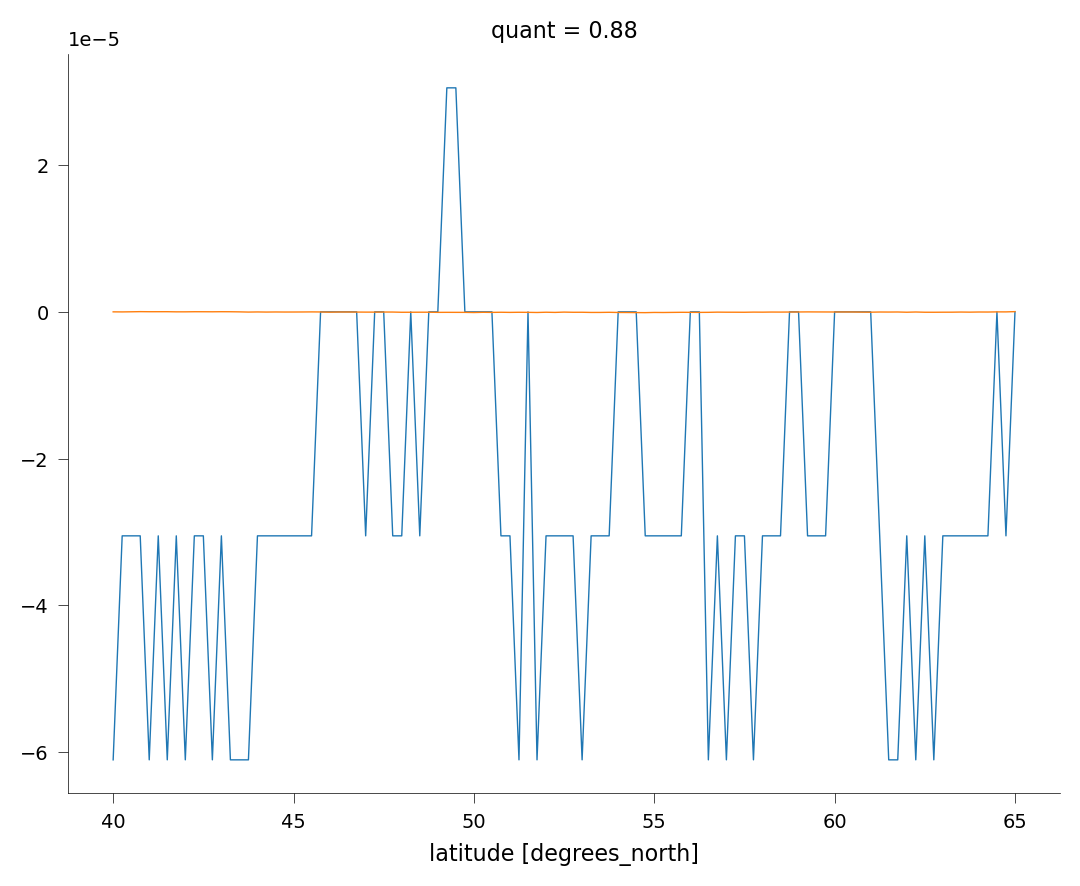

In [13]:
# Sanity check that T500 and rh_eff av made up of individual averages
(ds_av.t - (ds_av.t_zonal_av + ds_av.t_zonal_anom)).squeeze().plot()
(ds_av.rh_2m_eff - (ds_av.rh_2m + ds_av.rh_2m_eff_diff)).squeeze().plot()

### Theoretical $T_{2m}$ Estimate
Below, we compare the theory of $T_{2m}$ anomaly to the theory. It seems the theory systematically underestimates it. Maybe due to non-linear terms or in the error approximating $z_{500}$.

In [14]:
%%time
q_sat_ft, alpha_ft, beta_ft1 = get_theory_prefactor_terms(ds_av.t.squeeze(), ds_av.sp.squeeze(), ds.pressure_level.squeeze()*100)[1:4]

def get_temp_adiabat_surf_wrapper(rh2m, t, psurf):
    return get_temp_adiabat_surf(
        rh2m,
        t,
        None,
        pressure_surf=psurf,
        pressure_ft=float(ds_av.pressure_level.squeeze()*100),
        rh_form=True,
    )

ds_av['t2m_calc'] = xr.apply_ufunc(
    get_temp_adiabat_surf_wrapper,
    ds_av.rh_2m_eff.squeeze().broadcast_like(ds.sp.isel(sample=0).squeeze()),
    ds_av.t.squeeze().broadcast_like(ds.sp.isel(sample=0).squeeze()),
    ds.sp.squeeze().mean(dim="sample"),
    input_core_dims=[[], [], []],   # all treated as scalars
    output_core_dims=[[]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float],
)
ds_anom['t2m'] = ds.t2m - ds_av.t2m_calc            # anomaly to compare to calc is relative to this temp

q_sat_s, alpha_s, beta_s1 = get_theory_prefactor_terms(ds_av.t2m_calc.squeeze(),
                                                       ds_av.sp.squeeze(), ds.pressure_level.squeeze()*100,
                                                       sphum = ds_av.rh_2m_eff * sphum_sat(ds_av.t2m_calc, ds_av.sp).squeeze())[1:4]

t2m_cont_prefactor = {'t_zonal_av': beta_ft1 / beta_s1, 't_zonal_anom': beta_ft1 / beta_s1,
                      'rh_2m': -L_v * q_sat_s / beta_s1, 'rh_2m_eff_diff': -L_v * q_sat_s / beta_s1}
t2m_cont = {key: t2m_cont_prefactor[key] * ds_anom[key] for key in t2m_cont_prefactor}

CPU times: user 28.5 s, sys: 2.19 s, total: 30.7 s
Wall time: 38.8 s


In [15]:
t2m_theory = t2m_cont['t_zonal_av'].squeeze() * 0
for key in t2m_cont:
    t2m_theory = t2m_theory + t2m_cont[key].squeeze()

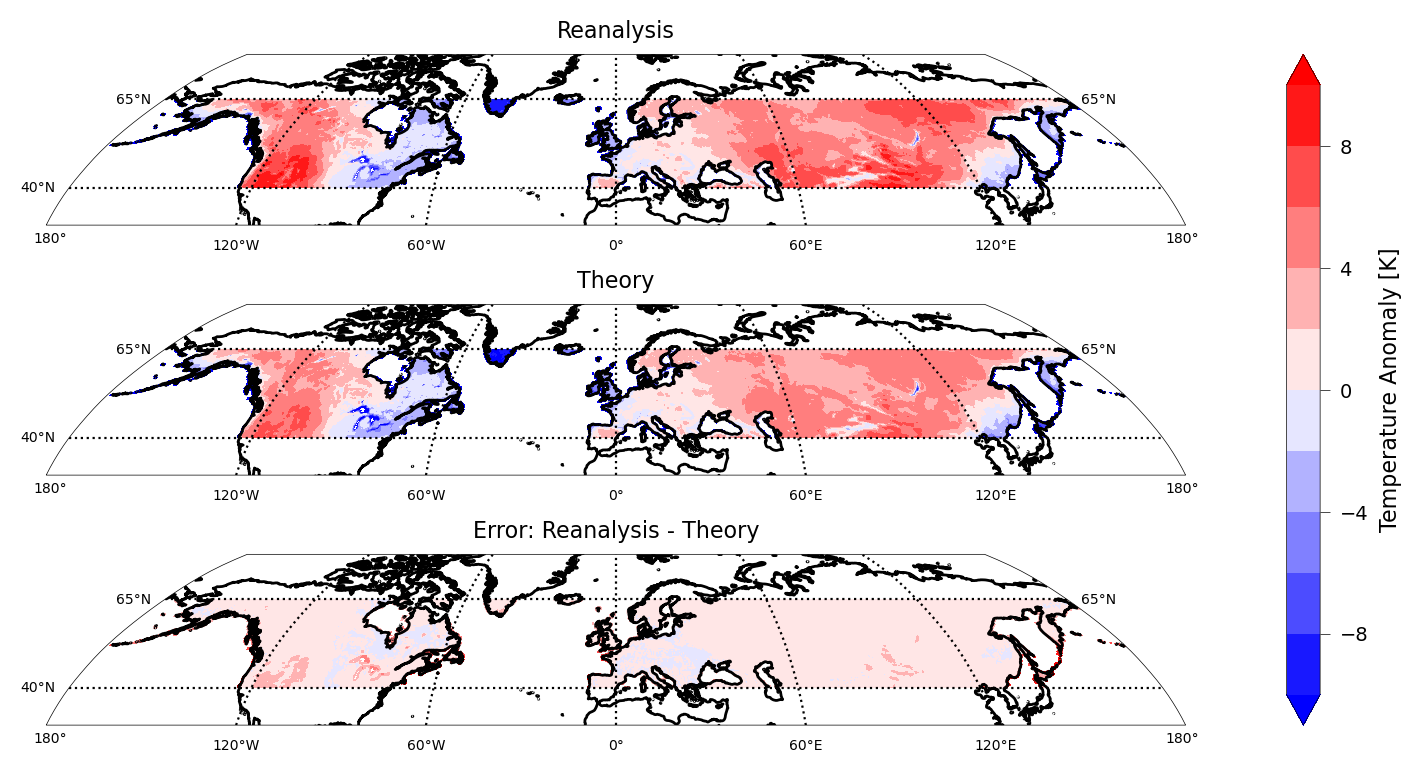

In [16]:
fig = plt.figure(constrained_layout=True)
ax = fig.subplots(3, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
fig_resize(fig, 10, ar=8)
for ax_use in ax:
    initialize_ax_projection(ax_use)
mask_use = ds.rh_2m_eff.where(land) < 1
plot_contour_projection(ax[0], ds_anom.t2m.where(mask_use).mean(dim='sample').squeeze(), cmap='bwr', levels=np.linspace(-10, 10, 11))
plot_contour_projection(ax[1], t2m_theory.where(mask_use).mean(dim='sample').squeeze(), cmap='bwr', levels=np.linspace(-10, 10, 11))
im = plot_contour_projection(ax[2], (ds_anom.t2m-t2m_theory).where(mask_use).mean(dim='sample').squeeze(), cmap='bwr', levels=np.linspace(-10, 10, 11))
plt.colorbar(im, ax=ax.ravel(), label='Temperature Anomaly [K]')
ax[0].set_title('Reanalysis')
ax[1].set_title('Theory')
ax[2].set_title('Error: Reanalysis - Theory')
plt.show()

### Clustering
Below, we cluster the $T_{2m}$ contribution from $T_{500}$ and $r_{2m,eff}$.

In [66]:
def cluster_t2m_masked(t2m_cont: dict, mask_use=land, k_range: range = range(2, 10)):
    """
    Cluster t2m_cont dictionary after masking NaNs.
    """

    # --- 1. Mask: only keep points where all 4 values are finite ---
    stacked = np.stack([da.where(mask_use).values for da in t2m_cont.values()], axis=0)  # (4, lat, lon, sample)
    mask = np.isfinite(stacked).all(axis=0)  # (lat, lon, sample)

    # --- 2. Extract valid features ---
    features = []
    for key in t2m_cont:
        features.append(t2m_cont[key].values[mask])
    X = np.stack(features, axis=1)  # (n_valid, 4)

    # --- 3. Normalize (L1/Manhattan) ---
    X_norm = normalize(X, norm="l1", axis=1)

    # --- 4. Find best k ---
    silhouette_scores = {}
    best_score = -1
    best_k, best_labels = None, None
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=0, n_init=10)
        labels = km.fit_predict(X_norm)
        if len(np.unique(labels)) > 1:
            score = silhouette_score(X_norm, labels)
            silhouette_scores[k] = score
            if score > best_score:
                best_score, best_k, best_labels = score, k, labels

    # --- 5. Reconstruct labels grid ---
    shape = next(iter(t2m_cont.values())).shape
    coords = next(iter(t2m_cont.values())).coords
    label_grid = np.full(shape, np.nan)
    label_grid[mask] = best_labels  # fill only valid points

    labels_da = xr.DataArray(
        label_grid,
        dims=("latitude", "longitude", "sample"),
        coords=coords
    )

    return {
        "labels": labels_da,
        "best_k": best_k,
        "silhouette_scores": silhouette_scores,
    }

mask_cluster = (ds.rh_2m_eff<1).where(land).squeeze()       # all convective days
X = np.stack([da.squeeze().where(mask_cluster).values for da in t2m_cont.values()], axis=0)
mask_stack = np.isfinite(X).all(axis=0)  # (lat, lon, sample)
X = X[:, mask_stack].T

# --- 3. Normalize (L1/Manhattan) ---
X_norm = normalize(X, norm="l1", axis=1)

# --- 4. Find best k ---
k_range = range(2, 3)
silhouette_scores = {}
best_score = -1
best_k, best_labels = None, None
for k in tqdm(k_range):
    km = KMeans(n_clusters=k, random_state=0, n_init=10)
    labels = km.fit_predict(X_norm)
    if len(np.unique(labels)) > 1:
        score = silhouette_score(X_norm, labels, sample_size=10000, random_state=0)     # use sub sample as very slow
        silhouette_scores[k] = score
        if score > best_score:
            best_score, best_k, best_labels = score, k, labels

label_grid = np.full(mask_stack.shape, np.nan)
label_grid[mask_stack] = best_labels
labels_da = xr.DataArray(
        label_grid,
        dims=("latitude", "longitude", "sample"),
        coords=t2m_cont['t_zonal_av'].squeeze().coords
    )

  0%|          | 0/1 [00:00<?, ?it/s]

### Most important contribution from each cluster
Below we see that the main difference between the clusters is in relative humidity. Cluster 0 is dry in physical terms, whereas the difference to effective humidity is larger for cluster 1.

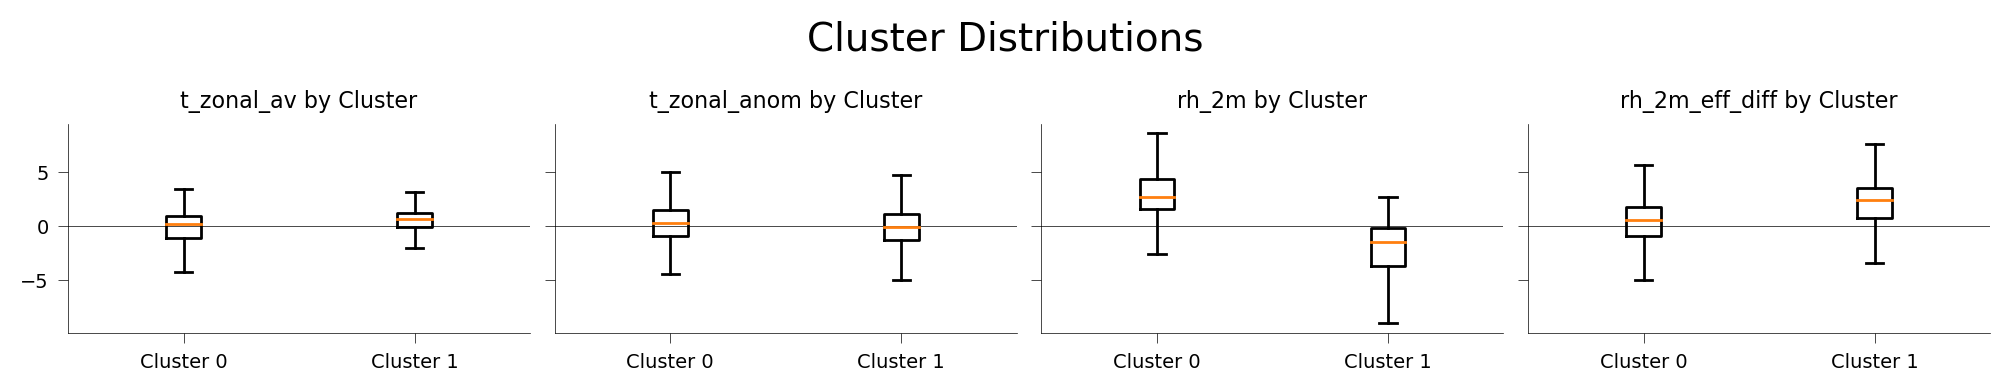

In [69]:
def plot_cluster_boxplots(t2m_cont: dict, labels_da: xr.DataArray, best_k: int = 2, show_norm=False):
    """
    Make boxplots of each variable in t2m_cont conditioned on cluster labels.

    Args:
        t2m_cont (dict[str, xr.DataArray]): Dictionary of variables (lat, lon, sample).
        labels_da (xr.DataArray): Cluster labels with same shape as t2m_cont values.
        best_k (int): Number of clusters (default 2).
    """
    n_vars = len(t2m_cont)
    fig, axes = plt.subplots(1, n_vars, sharey=True)
    fig_resize(fig, 10)
    if show_norm:
        norm = t2m_cont['t_zonal_av'] * 0
        for key in t2m_cont:
            norm = norm + np.abs(t2m_cont[key])
    else:
        norm = 1

    for ax, (key, da) in zip(axes, t2m_cont.items()):
        data_per_cluster = []
        for k in range(best_k):
            vals = (da/norm).where(labels_da == k).values.ravel()
            vals = vals[np.isfinite(vals)]  # drop NaNs
            data_per_cluster.append(vals)

        ax.boxplot(data_per_cluster, labels=[f"Cluster {k}" for k in range(best_k)], showfliers=False)
        ax.set_title(f"{key} by Cluster")
        ax.axhline(0, color='k', lw=ax_linewidth)
    fig.suptitle("Cluster Distributions", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
plot_cluster_boxplots(t2m_cont, labels_da, best_k=best_k)

### Distribution of Clusters
We see a clear spatial variation in the fraction of hot days in a given cluster. This correlates quite well with the $T_{2m}$ anomaly as well: cluster 0 tends to be hotter.

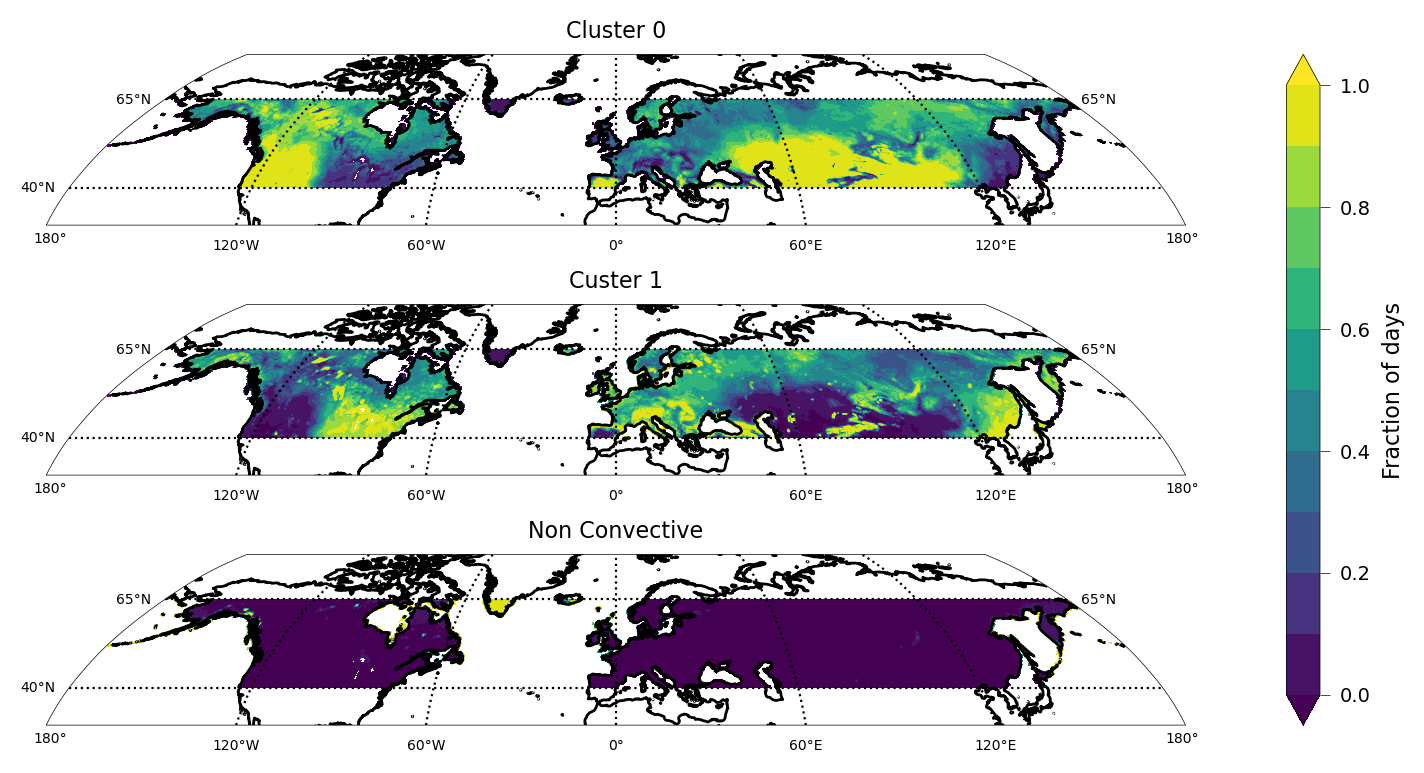

In [76]:
fig = plt.figure(constrained_layout=True)
ax = fig.subplots(3, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
fig_resize(fig, 10, ar=8)
for ax_use in ax:
    initialize_ax_projection(ax_use)
n_sample = (ds.t2m.where(land)>0).sum(dim='sample').squeeze()
contour_lev = np.linspace(0, 1, 11)
plot_contour_projection(ax[0], (labels_da==0).sum(dim='sample')/n_sample, levels=contour_lev)
plot_contour_projection(ax[1], (labels_da==1).sum(dim='sample')/n_sample, levels=contour_lev)
im = plot_contour_projection(ax[2], (ds.rh_2m_eff>1).sum(dim='sample').squeeze()/n_sample,
                             levels=contour_lev)
plt.colorbar(im, ax=ax.ravel(), label='Fraction of days')
ax[0].set_title('Cluster 0')
ax[1].set_title('Custer 1')
ax[2].set_title('Non Convective')
plt.show()

### $T_{2m}$ Anomaly conditioned on cluster
Below we see in a given region, days of cluster 0 are hotter than cluster 1.

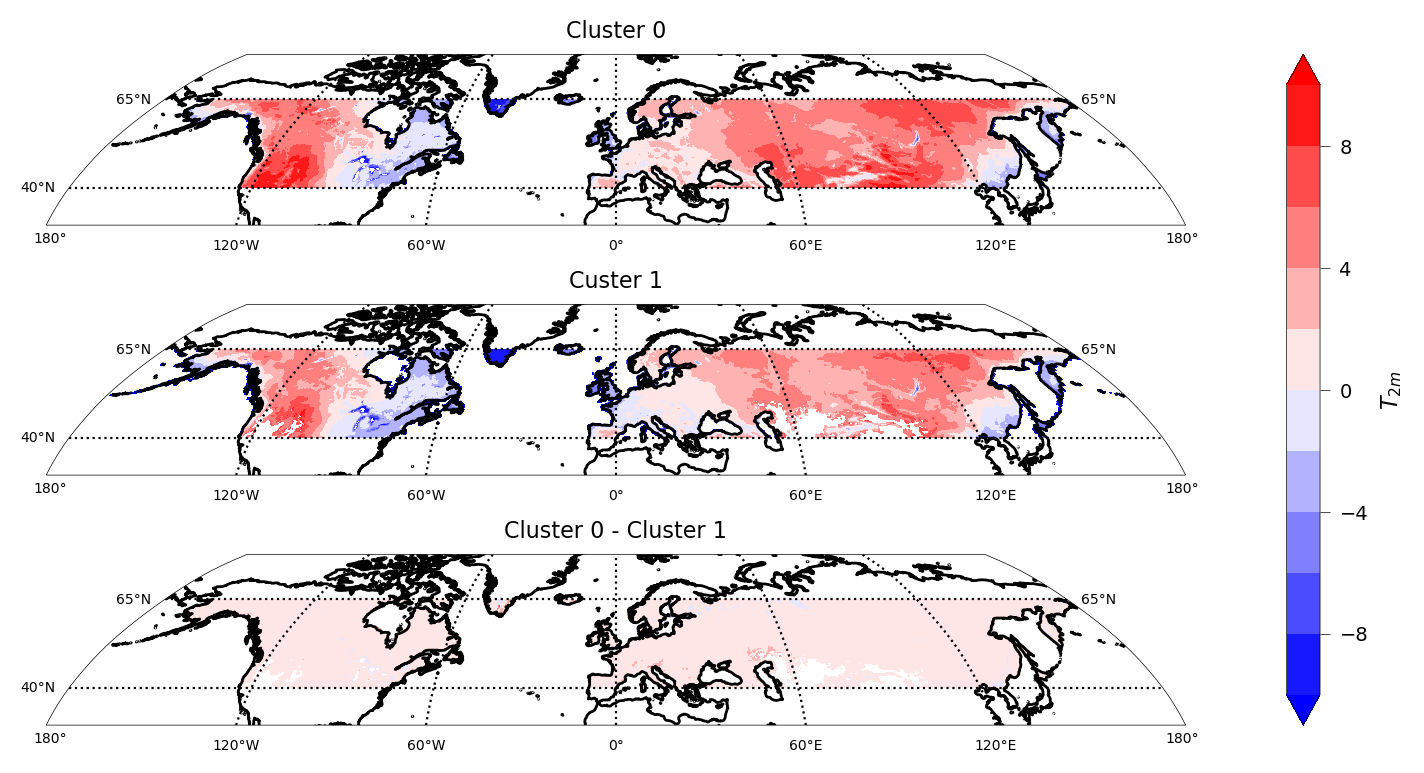

In [87]:
fig = plt.figure(constrained_layout=True)
ax = fig.subplots(3, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
fig_resize(fig, 10, ar=8)
for ax_use in ax:
    initialize_ax_projection(ax_use)
n_sample = (ds.t2m.where(land)>0).sum(dim='sample').squeeze()
contour_lev = np.linspace(-10, 10, 11)
plot_contour_projection(ax[0], ds_anom.t2m.squeeze().where(labels_da==0).mean(dim='sample'), levels=contour_lev, cmap='bwr')
plot_contour_projection(ax[1], ds_anom.t2m.squeeze().where(labels_da==1).mean(dim='sample'), levels=contour_lev, cmap='bwr')
im = plot_contour_projection(ax[2], ds_anom.t2m.squeeze().where(labels_da==0).mean(dim='sample') -
                             ds_anom.t2m.squeeze().where(labels_da==1).mean(dim='sample'),
                             levels=contour_lev, cmap='bwr')
plt.colorbar(im, ax=ax.ravel(), label='$T_{2m}$')
ax[0].set_title('Cluster 0')
ax[1].set_title('Custer 1')
ax[2].set_title('Cluster 0 - Cluster 1')
plt.show()

### Fraction of days in a given cluster vary with time?
How does the number of days in a given cluster vary with time?

In regions with non convective days, the rate of increase of non convective days seems larger than that of convective days, maybe a bit surprising.

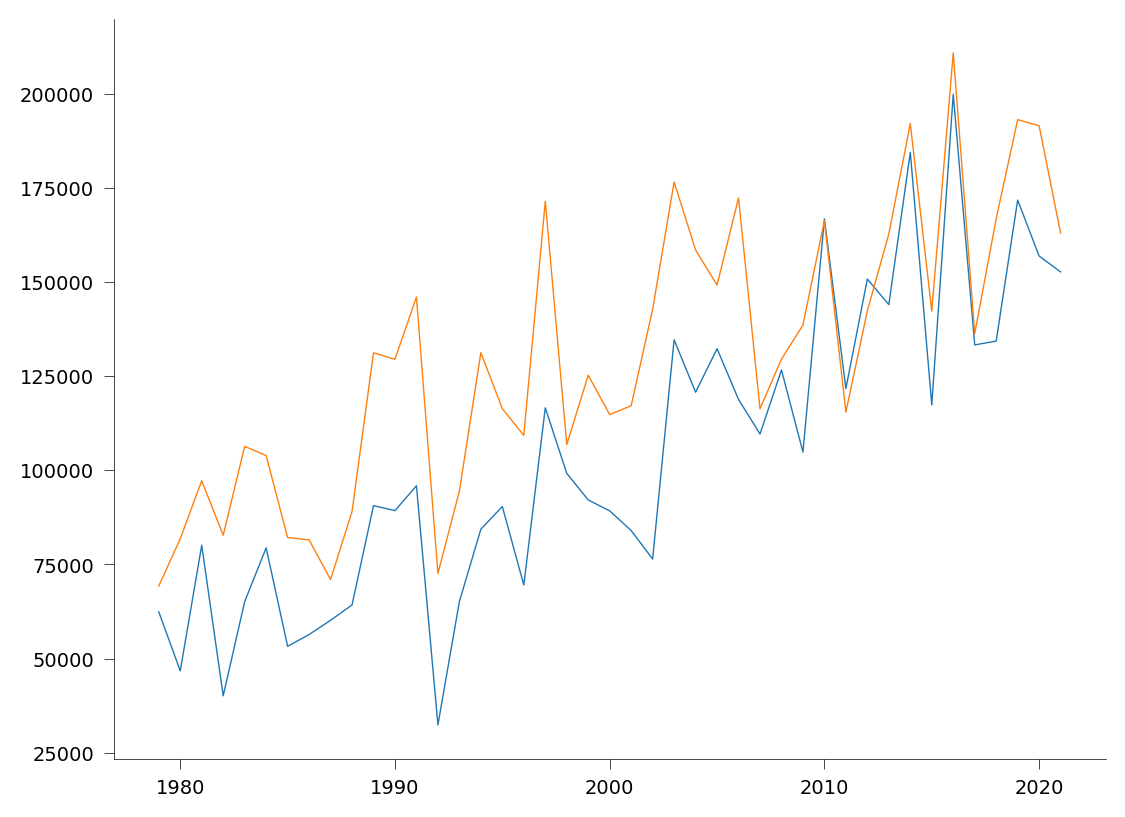

In [107]:
reg_non_conv = (ds.rh_2m_eff>1).sum(dim='sample').where(land).squeeze()>0
var = np.unique(ds.where(ds.rh_2m_eff.where(reg_non_conv)>1).time.squeeze().dt.year, return_counts=True)
plt.plot(var[0], var[1])
var = np.unique(ds.where(ds.rh_2m_eff.where(reg_non_conv)<1).time.squeeze().dt.year, return_counts=True)
plt.plot(var[0], var[1])
# var = np.unique(ds.where(~land).time.squeeze().dt.year, return_counts=True)
# plt.plot(var[0], var[1])

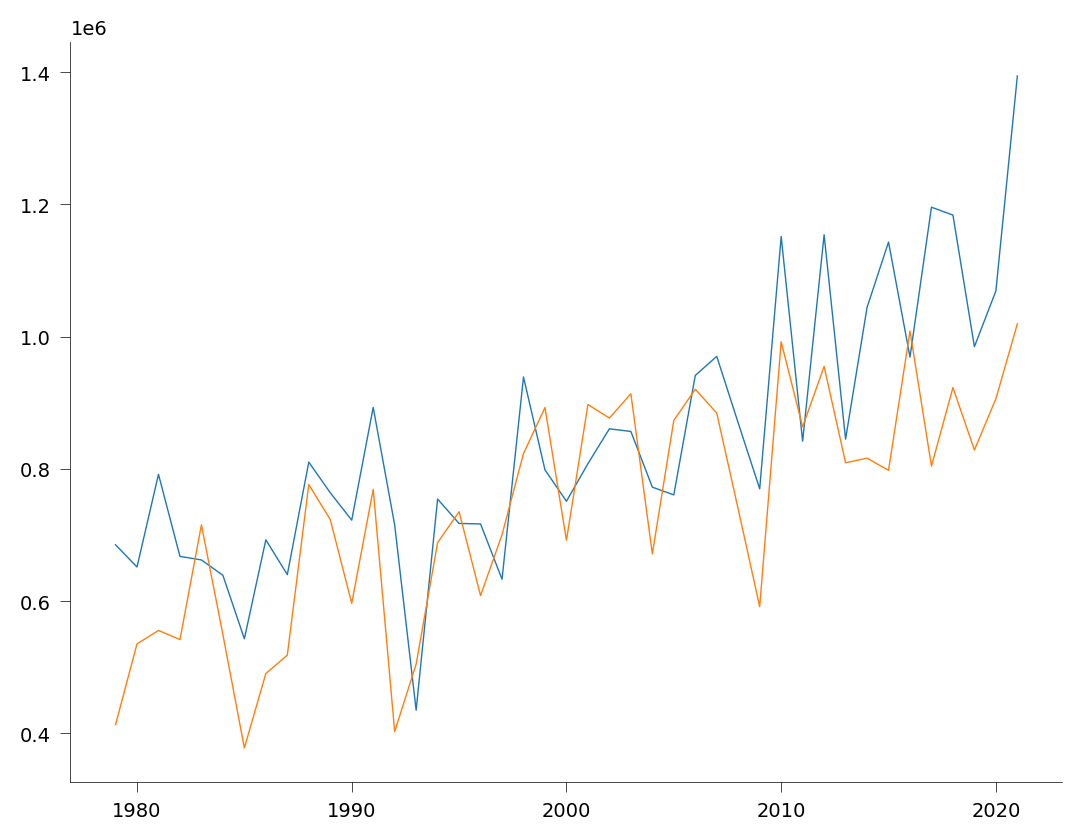

In [88]:
var = np.unique(ds.where(labels_da==0).time.squeeze().dt.year, return_counts=True)
plt.plot(var[0], var[1])
var = np.unique(ds.where(labels_da==1).time.squeeze().dt.year, return_counts=True)
plt.plot(var[0], var[1])